In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# Explore Data

In [2]:
df = pd.read_csv('./GSE150150_raw_counts.csv')

In [3]:
columns = ["Trunk E9.5", "Trunk E10.5", "DRG E9.5", "DRG E10.5", "DRG E11.5", "DRG E12.5", "Cranio E12.5"]
idMappings = {
    "SS2_15_0085": "Trunk E9.5",
    "SS2_18_107": "Trunk E10.5",
    "SS2_18_108": "Trunk E10.5",
    "SS2_18_109": "Trunk E10.5",
    "SS2_16_767": "DRG E9.5",
    "SS2_17_435": "DRG E9.5",
    "SS2_16_688": "DRG E10.5",
    "SS2_16_769": "DRG E10.5",
    "SS2_17_432": "DRG E10.5",
    "SS2_17_433": "DRG E10.5",
    "SS2_16_385": "DRG E11.5",
    "SS2_16_384": "DRG E12.5",
    "SS2_15_0073": "Cranio E12.5",
    "SS2_15_0169": "Cranio E12.5"
}

In [4]:
print("Gene Count: ", len(df))
sampleRow = df.sample()
print("Sample Row: ", sampleRow)
print("Sample Gene: ", sampleRow.iloc[0,0])

Gene Count:  24582
Sample Row:          Gene  SS2_15_0073:A9_unique.bam  SS2_15_0073:A8_unique.bam  \
2350  Hoxd12                          0                          0   

      SS2_15_0073:A7_unique.bam  SS2_15_0073:A6_unique.bam  \
2350                          0                          0   

      SS2_15_0073:A5_unique.bam  SS2_15_0073:A4_unique.bam  \
2350                          0                          0   

      SS2_15_0073:A3_unique.bam  SS2_15_0073:A2_unique.bam  \
2350                          0                          0   

      SS2_15_0073:A10_unique.bam  ...  SS2_15_0085:P15_unique.bam  \
2350                           0  ...                           0   

      SS2_15_0085:P16_unique.bam  SS2_15_0085:P17_unique.bam  \
2350                           0                           0   

      SS2_15_0085:P18_unique.bam  SS2_15_0085:P19_unique.bam  \
2350                           0                           0   

      SS2_15_0085:P20_unique.bam  SS2_15_0085:P24_uniqu

In [5]:
import numbers
df.columns = [idMappings[col.split(":")[0]] if col.split(":")[0] in idMappings else col for col in df.columns]
dfParsed = df.groupby(df.columns, axis=1).apply(lambda x: x.mean(axis=1) if isinstance(x.iloc[0,0], numbers.Number) else x.iloc[:,0])
dfParsed = dfParsed[dfParsed.columns[5:].tolist() + dfParsed.columns[:5].tolist()]

print("Grouped Gene Count: ", len(dfParsed))
sampleRow = dfParsed.sample()
print("Grouped Sample Row: ", sampleRow)
print("Grouped Sample Gene: ", sampleRow.iloc[0,0])

Grouped Gene Count:  24582
Grouped Sample Row:          Gene  Trunk E10.5  Trunk E9.5  Cranio E12.5  DRG E10.5  DRG E11.5  \
2381  Zc3h15    29.746528   58.578125     42.153646  47.266927  51.109375   

      DRG E12.5   DRG E9.5  
2381  46.841146  54.032552  
Grouped Sample Gene:  Zc3h15


### Other Trials

In [6]:
# Single column of data
singleCellData = df.iloc[:,10:13] # 10 and 11th column, random
print(singleCellData)

       Cranio E12.5  Cranio E12.5  Cranio E12.5
0               950          5505          3516
1               570          1752          1197
2               104          1148           491
3               200           886           431
4                 2             0             0
...             ...           ...           ...
24577             0             0             0
24578             0             0             0
24579             0             0             0
24580             0             0             0
24581             0             0             0

[24582 rows x 3 columns]


In [7]:
# Normalized data (Log Transformation)
dfWithoutGene = dfParsed.iloc[:, 1:]
sumDf = dfWithoutGene.sum(axis=0)
normalizedDf = dfWithoutGene.div(sumDf, axis=1)
normalizedDf = normalizedDf + 1
normalizedDf = np.log(normalizedDf)
print(normalizedDf)

        Trunk E10.5    Trunk E9.5  Cranio E12.5     DRG E10.5     DRG E11.5  \
0      5.653901e-05  8.998528e-03      0.016388  8.746108e-04  1.004989e-03   
1      6.168120e-06  3.168680e-03      0.005928  1.872048e-04  1.804275e-04   
2      5.534983e-06  1.282956e-03      0.002384  1.121967e-04  1.220574e-04   
3      5.216424e-06  1.228325e-03      0.002734  9.646657e-05  1.257768e-04   
4      0.000000e+00  3.382103e-06      0.000008  6.969757e-07  6.131517e-08   
...             ...           ...           ...           ...           ...   
24577  0.000000e+00  0.000000e+00      0.000000  0.000000e+00  0.000000e+00   
24578  0.000000e+00  0.000000e+00      0.000000  0.000000e+00  0.000000e+00   
24579  0.000000e+00  0.000000e+00      0.000000  0.000000e+00  0.000000e+00   
24580  0.000000e+00  0.000000e+00      0.000000  0.000000e+00  0.000000e+00   
24581  4.778416e-08  9.608263e-09      0.000000  1.828800e-08  6.812797e-09   

          DRG E12.5      DRG E9.5  
0      1.532655

# K-Means Clustering

In [8]:
from sklearn.cluster import KMeans

# Get 5 Random Rows for POC
# sampleDf = df.sample(5)

sampleDf = dfParsed

# X is shape of (24582, 7)
# Getting gene counts across all samples
X = sampleDf.iloc[:,1:].values

In [9]:
# Other Normalized Data Frames

# X = singleCellData.iloc[:,1:].values
# print(X)

# X = normalizedDf.iloc[:,1:].values
# print(X)

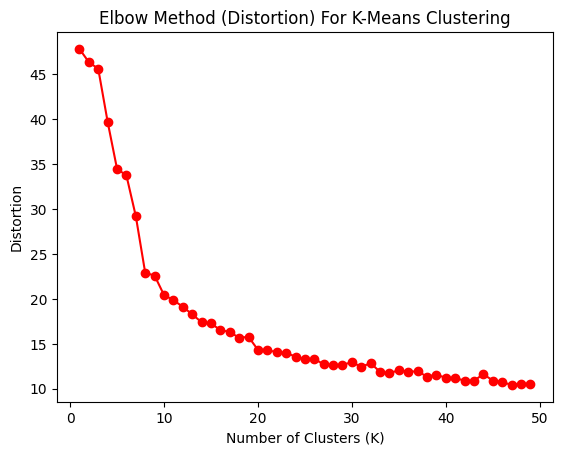

In [10]:
# Elbow Method
from scipy.spatial.distance import cdist

distortions = []
K = range(1, 50)
  
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(X)
    kmeanModel.fit(X)
  
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    

plt.plot(K, distortions, 'ro-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Distortion')
plt.title('Elbow Method (Distortion) For K-Means Clustering')
plt.show()

In [11]:
kmeans = KMeans(n_clusters=19, random_state=0).fit(X)
print("Cluster Centers: ", kmeans.cluster_centers_)
print("Labels: ", kmeans.labels_)

Cluster Centers:  [[1.07186835e+00 1.04222221e+00 1.61046521e+00 1.53417858e+00
  1.77095038e+00 1.81500720e+00 1.52740412e+00]
 [7.12413194e+00 5.24833594e+03 1.27361576e+04 3.47263021e+02
  3.64101562e+02 5.37460938e+02 7.01029948e+02]
 [6.21848177e+03 5.81102865e+03 3.57358724e+03 5.45322982e+03
  8.56351823e+03 8.26549219e+03 6.32161719e+03]
 [1.11313440e+02 1.35449978e+02 2.17514540e+02 3.10648953e+02
  5.13818793e+02 4.29373915e+02 2.04498155e+02]
 [1.13851273e+01 2.27587587e+03 5.25451519e+03 2.55435547e+02
  3.81854167e+02 5.17945312e+02 6.26366319e+02]
 [7.99128609e+01 1.09303161e+02 1.02408383e+02 1.03980518e+02
  9.53329036e+01 9.25508518e+01 1.14386898e+02]
 [1.42048512e+02 2.24908040e+02 2.25203613e+02 1.85019769e+02
  1.71529324e+02 1.71833008e+02 2.17727146e+02]
 [1.16089280e+03 1.48959245e+03 1.17439714e+03 1.58409668e+03
  1.44119401e+03 1.34787240e+03 1.54970768e+03]
 [2.76460503e+02 4.80921528e+02 3.43488715e+02 3.43543728e+02
  3.16636632e+02 3.13064149e+02 4.429846

In [12]:
unique, counts = np.unique(kmeans.labels_, return_counts=True)
print("Label Counts: ", dict(zip(unique, counts)))


Label Counts:  {0: 17623, 1: 1, 2: 1, 3: 24, 4: 3, 5: 407, 6: 96, 7: 2, 8: 30, 9: 6, 10: 444, 11: 3, 12: 7, 13: 2, 14: 1401, 15: 87, 16: 4441, 17: 3, 18: 1}


/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


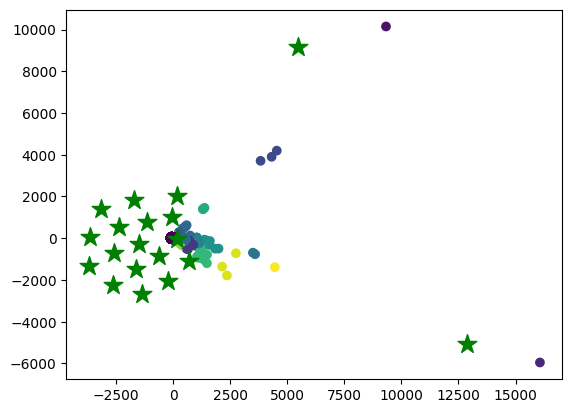

In [13]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, learning_rate=200, init='pca')
X_tsne = tsne.fit_transform(X)
cluster_tsne = tsne.fit_transform(kmeans.cluster_centers_)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans.labels_)
plt.scatter(cluster_tsne[:, 0], cluster_tsne[:, 1], marker='*', s=200, c='green')
plt.show()


In [14]:
import umap
standard_embedding = umap.UMAP(random_state=42).fit_transform(X)


/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


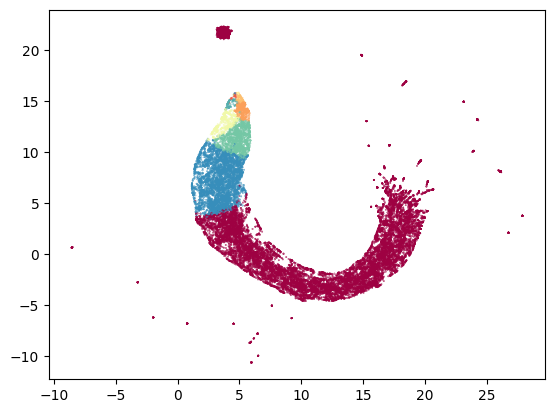

In [15]:
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=kmeans.labels_, s=0.1, cmap='Spectral')

In [16]:
Nociception = ["Ntrk1", "Runx1", "Prdm12", "Th", "Scn10a", "Syt13", "Stra6", "Gal", "Prdm8"]
Mechanoreception1 = ["Pdlim1","Mmd2", "Pou4f3", "Rnf144a"]
Mechanoreception2 = ["Pou6f2", "Dio3", "Onecut3", "Tbx2", "Gpx3", "Ret"]
Proprioception = ["Ntrk3", "Runx3", "Mgst3", "Fam19a4", "Pcp4", "Grm3"]
Fate1 = ["Runx3", "Nfia"]
Fate2 = ["Pou6f2", "Nr5a2", "Hoxb5", "Pdlim1", "Egr1"]
Fate3 = ["Tcf15", "Pdlim1"]
Fate4 = ["Pou6f2", "Onecut3", "Dcc"]

NociceptionCluster = []
Mechanoreception1Cluster = []
Mechanoreception2Cluster = []
ProprioceptionCluster = []
Fate1Cluster = []
Fate2Cluster = []
Fate3Cluster = []
Fate4Cluster = []

for gene in Nociception:
    NociceptionCluster.append(kmeans.labels_[dfParsed[dfParsed["Gene"] == gene].index[0]])

for gene in Mechanoreception1:
    Mechanoreception1Cluster.append(kmeans.labels_[dfParsed[dfParsed["Gene"] == gene].index[0]])

for gene in Mechanoreception2:
    Mechanoreception2Cluster.append(kmeans.labels_[dfParsed[dfParsed["Gene"] == gene].index[0]])

for gene in Proprioception:
    ProprioceptionCluster.append(kmeans.labels_[dfParsed[dfParsed["Gene"] == gene].index[0]])

for gene in Fate1:
    Fate1Cluster.append(kmeans.labels_[dfParsed[dfParsed["Gene"] == gene].index[0]])

for gene in Fate2:
    Fate2Cluster.append(kmeans.labels_[dfParsed[dfParsed["Gene"] == gene].index[0]])
    
for gene in Fate3:
    Fate3Cluster.append(kmeans.labels_[dfParsed[dfParsed["Gene"] == gene].index[0]])

for gene in Fate4:
    Fate4Cluster.append(kmeans.labels_[dfParsed[dfParsed["Gene"] == gene].index[0]])


print("Nociception Cluster: ", NociceptionCluster)
print("Mechanoreception1 Cluster: ", Mechanoreception1Cluster)
print("Mechanoreception2 Cluster: ", Mechanoreception2Cluster)
print("Proprioception Cluster: ", ProprioceptionCluster)
print("Fate1 Cluster: ", Fate1Cluster)
print("Fate2 Cluster: ", Fate2Cluster)
print("Fate3 Cluster: ", Fate3Cluster)
print("Fate4 Cluster: ", Fate4Cluster)

Nociception Cluster:  [10, 0, 16, 16, 0, 10, 16, 16, 0]
Mechanoreception1 Cluster:  [10, 16, 0, 16]
Mechanoreception2 Cluster:  [0, 0, 0, 0, 14, 16]
Proprioception Cluster:  [10, 16, 16, 16, 16, 0]
Fate1 Cluster:  [16, 16]
Fate2 Cluster:  [0, 0, 16, 10, 14]
Fate3 Cluster:  [0, 10]
Fate4 Cluster:  [0, 0, 16]


# Conclusion

Relatively poor results with K-Means. Even after normalizing data, preprocessing via averages or using a single column, we don't get good clusters.